In [ ]:
# terminology:
# obs_mask:  1 = observed,   0 = hole
# hole_mask: 1 = hole,       0 = not hole (observed)


# Absolutely lovely state of typesafety in this godforsaken ecosystem. We will use underscores a lot ...
# I will try to minimize usage of tf.cast


# we place emphasis on determinism


import os, time, glob, subprocess, sys, uuid
from tqdm import tqdm
from datetime import datetime


import psycopg2
from psycopg2.extras import execute_values
from psycopg2.extras import Json

conn = psycopg2.connect(
    dbname="mldb", user="navid", password="123", host="localhost", port="5432"
)
conn.autocommit = True
cur = conn.cursor()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf


config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras
import random
import numpy as np
import matplotlib.pyplot as plt

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)


# keras.mixed_precision.set_global_policy("mixed_bfloat16")
FLOAT = tf.float32

2025-05-24 22:31:24.145279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748113284.188602    3295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748113284.201775    3295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-24 22:31:30.876856: E tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:55] The TF_FORCE_GPU_ALLOW_GROWTH environment variable is set but could not be parsed: "1". Valid values are "true" or "false". Using original config value of 1.
I0000 00:00:1748113290.878803    3295 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3401 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Lapto

In [ ]:
def viz_img(img):
    img = tf.cast(img, tf.float32)
    plt.imshow(tf.squeeze(img).numpy(), cmap="gray")
    plt.colorbar()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    plt.text(
        0.99,
        0.01,
        timestamp,
        ha="right",
        va="bottom",
        transform=plt.gca().transAxes,
        fontsize=12,
        color="white",
        alpha=0.9,
        bbox=dict(boxstyle="square,pad=0.1", facecolor="black", alpha=0.3),
    )
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    plt.text(
        0.99,
        0.01,
        timestamp,
        ha="right",
        va="bottom",
        transform=plt.gca().transAxes,
        fontsize=12,
        color="white",
        alpha=0.9,
        bbox=dict(boxstyle="square,pad=0.1", facecolor="black", alpha=0.3),
    )
    plt.show()


def viz_grid(batch: tf.Tensor, max: int = 4):
    batch_size: int = batch.shape[0]  # type: ignore
    num = min(batch_size, max)
    fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(15, 15), dpi=300)
    if num == 1:
        axes = [axes]
    for i in range(num):
        # Original image
        axes[i].imshow(
            tf.clip_by_value(
                tf.cast(batch[i], dtype=tf.float32), 0, 1  # type: ignore
            ).numpy()  # type: ignore
        )
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


def random_obs_mask(H, W, MASK_MIN_SIZE, MASK_MAX_SIZE):
    "-> [0,1]^{H x W x C}, dtype=FLOAT"
    w, h = [np.random.randint(MASK_MIN_SIZE, MASK_MAX_SIZE + 1) for _ in range(2)]
    x = np.random.randint(0, W - w + 1)
    y = np.random.randint(0, H - h + 1)

    # Start with all ones (observed pixels)
    mask = tf.ones((H, W), dtype=FLOAT)

    ys = tf.range(y, y + h)
    xs = tf.range(x, x + w)
    yy, xx = tf.meshgrid(ys, xs, indexing="ij")
    indices = tf.stack([yy, xx], axis=-1)
    indices = tf.reshape(indices, (-1, 2))

    # Set the hole region to zero
    updates = tf.zeros((h * w,), dtype=FLOAT)
    mask = tf.tensor_scatter_nd_update(mask, indices, updates)

    return tf.expand_dims(mask, -1)


def load_and_validate(file_path, ds_shape_advertised):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(
        img, channels=ds_shape_advertised[2], expand_animations=False
    )
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant(ds_shape_advertised)))

    return img, is_valid

I0000 00:00:1748113291.600820    3295 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3401 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Valid images count: 500
Trn,Tst,Val: 400 50 50
Trn,Tst,Val batches: 7 1 1


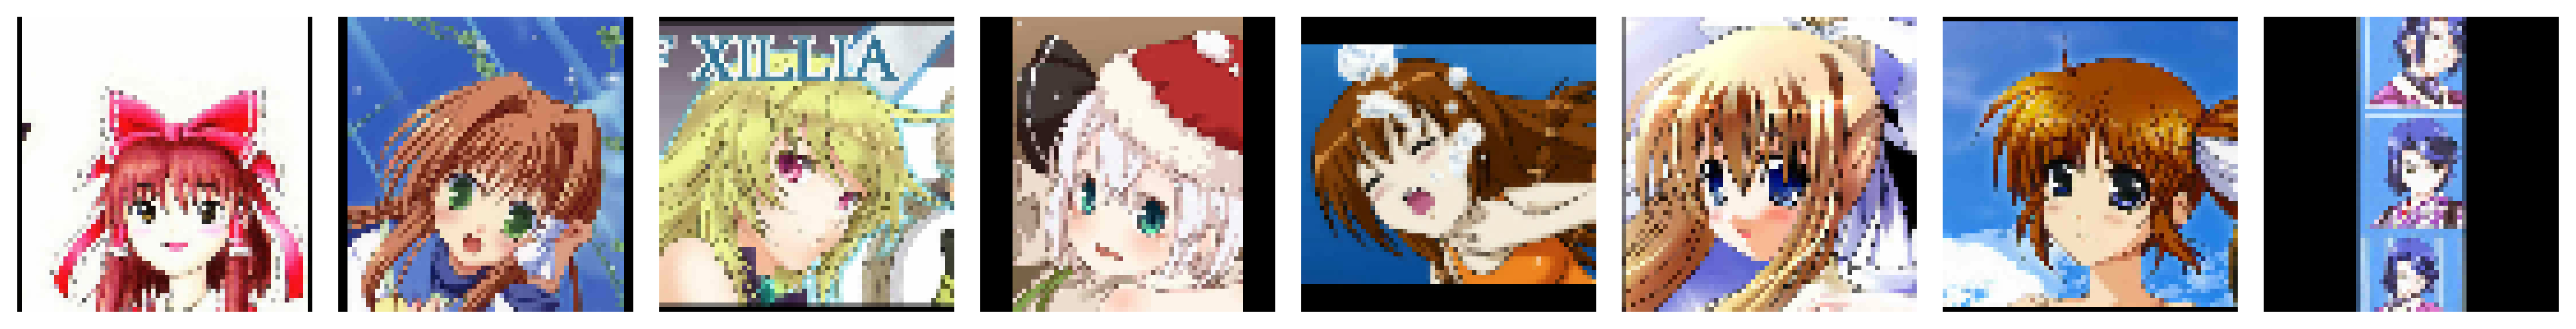

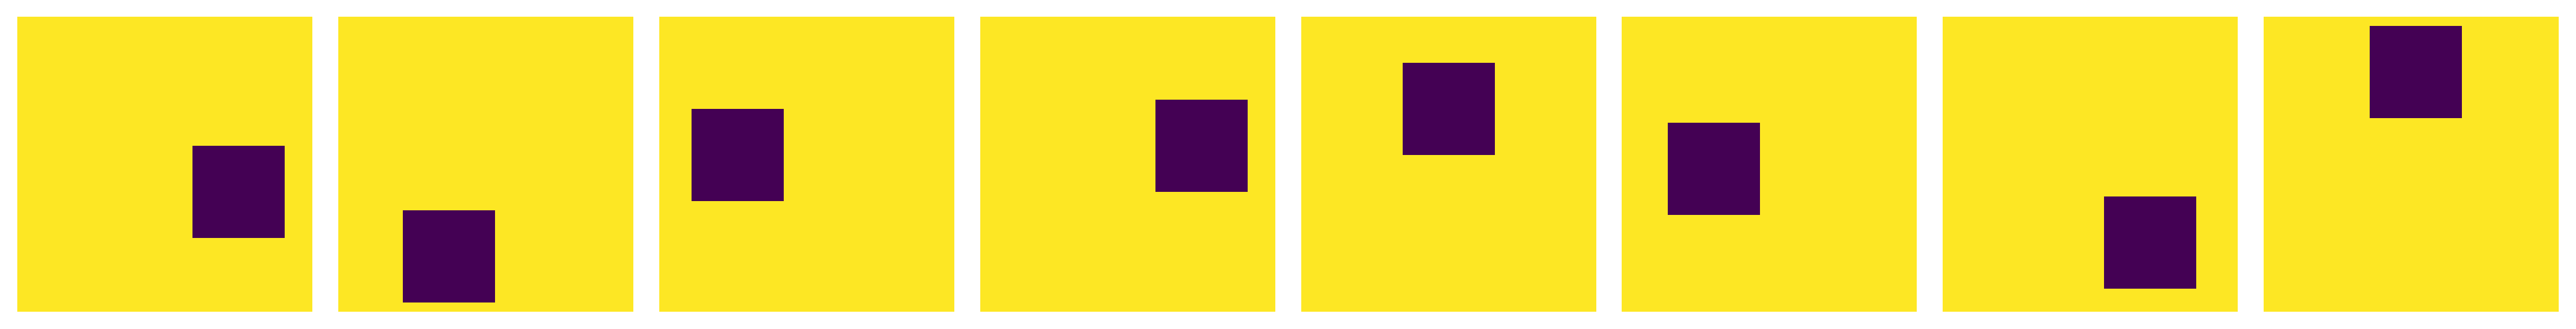

In [ ]:
H = 64
W = 64
C = 3

P = 16
assert H == W
assert H % P == 0

h = 8

D_model = P**2 * C
D_head = 128
D_fcn = 1024
num_layers = 8
N = (H * W) // (P * P)
BATCH_SIZE = 64


MASK_MAX_SIZE = 20
MASK_MIN_SIZE = 20
assert MASK_MAX_SIZE < H


ds_shape_advertised = (512, 512, 3)
dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 500


all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(lambda img: load_and_validate(img, ds_shape_advertised))
dataset = dataset.filter(lambda img, is_valid: is_valid)
dataset = dataset.map(lambda img, is_valid: img)
dataset = dataset.map(lambda img: tf.image.resize(img, (H, W)))

# tf.print(next(iter(dataset.take(1)))[0].dtype)
# with tf.device("/cpu:0"):
valid_count = dataset.reduce(
    tf.constant(0, dtype=tf.int32), lambda x, _: x + 1
).numpy()  # type: ignore

print(f"Valid images count: {valid_count}")
assert valid_count, "Everything's gone"

masks = [
    random_obs_mask(H, W, MASK_MIN_SIZE, MASK_MAX_SIZE) for _ in range(valid_count)
]
mask_ds = tf.data.Dataset.from_tensor_slices(masks)

ds = tf.data.Dataset.zip((dataset, mask_ds))


train_count = int(valid_count * 0.8)
test_count = int(valid_count * 0.1)
val_count = valid_count - train_count - test_count

train_ds = ds.take(train_count).batch(BATCH_SIZE)
test_ds = ds.skip(train_count).take(test_count).batch(BATCH_SIZE)
val_ds = ds.skip(train_count + test_count).take(val_count).batch(BATCH_SIZE)

train_batches = -(train_count // -BATCH_SIZE)
test_batches = -(test_count // -BATCH_SIZE)
val_batches = -(val_count // -BATCH_SIZE)

print("Trn,Tst,Val:", train_count, test_count, val_count)
print("Trn,Tst,Val batches:", train_batches, test_batches, val_batches)
viz_grid(next(iter(train_ds.take(1).map(lambda img, mask: img))), 8)  # type: ignore
viz_grid(next(iter(train_ds.take(1).map(lambda img, mask: mask))), 8)  # type: ignore

<dtype: 'float32'>


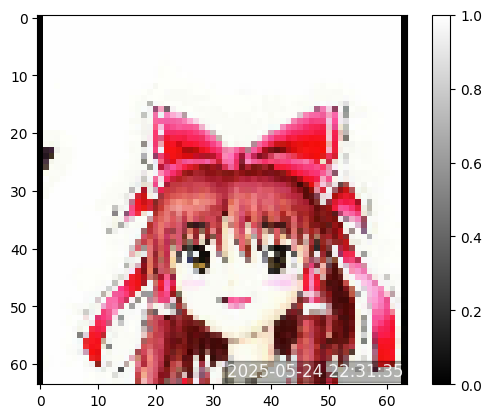

In [4]:
def extract_patches(image: tf.Tensor) -> tf.Tensor:
    "R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,
        sizes=[1, P, P, 1],
        strides=[1, P, P, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    BS, H_prime, W_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [BS, H_prime * W_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    "R^{BS x N x P.P.C} -> R^{BS x H x W x C}"
    BS = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P
    patches = tf.reshape(patches, [BS, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
    image = tf.reshape(patches, [BS, grid_size * P, grid_size * P, C])

    return image


sample = tf.expand_dims(next(iter(dataset.take(1))), 0)
tf.assert_equal(patches_to_imgs(extract_patches(sample)), sample)


def create_attention_mask(obs_mask_bool: tf.Tensor):
    "R^{BS x H x W} -> R^{BS x N x N}"
    # TF does not support native min pooling.
    # The mask shown is OBSERVATION MASK meaning 0 means missing.

    BS = tf.shape(obs_mask_bool)[0]
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(tf.logical_not(obs_mask_bool), dtype=tf.int8),
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [BS, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    A = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penanly
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )
    return A


def apply_obsv_mask(image: tf.Tensor, obs_mask_float: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, obs_mask_float)


def reconstruct(
    original: tf.Tensor, reconstruct: tf.Tensor, obs_mask_float: tf.Tensor
) -> tf.Tensor:
    obs_mask_bool = tf.cast(obs_mask_float, dtype=tf.bool)
    return tf.add(
        tf.multiply(tf.cast(obs_mask_bool, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obs_mask_bool), FLOAT), reconstruct),
    )


sample = next(iter(train_ds.unbatch().take(1)))
print(sample[0].dtype)
viz_img(sample[0])
# viz_mask(sample[1])

In [ ]:
commonDense = {"dtype": FLOAT, "kernel_initializer": initializer}


class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj = keras.layers.Dense(D_model, **commonDense)  # (P² * C) -> D_model

    def build(self, input_shape):
        self.positional_embedding = self.add_weight(
            shape=(N, D_model), initializer=initializer, name="pos_embed"
        )

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat)
        X += self.positional_embedding
        return X


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        # Project to h * D_head dimensions
        self.W_Q = keras.layers.Dense(h * D_head, **commonDense)
        self.W_K = keras.layers.Dense(h * D_head, **commonDense)
        self.W_V = keras.layers.Dense(h * D_head, **commonDense)
        # Project back to D_model
        self.W_O = keras.layers.Dense(D_model, **commonDense)

    def call(self, X, A):
        """
        X: R^{BS x N x D_model}, A: R^{BS x N x N} -> R^{BS x N x D_model}
        """

        # In the standard implementation, each head has its own separate projection matrices. However, a common optimization is to project the input into h * D_head dimensions (which is D_model) with a single large projection, then split into h heads. So, if D_model = h * D_head, then using a Dense(D_model) for Q, K, V and then splitting into h heads each of D_head is equivalent to having h separate projections. This is a standard approach because it's more efficient to compute all heads in parallel with a single matrix multiplication rather than h separate ones.
        # So the optimal way is to use combined projections.
        Q = self.W_Q(X)  # (BS, N, h * D_head)
        K = self.W_K(X)  # (BS, N, h * D_head)
        V = self.W_V(X)  # (BS, N, h * D_head)

        Q = tf.reshape(Q, (-1, N, h, D_head))  # (BS, N, h, D_head)
        K = tf.reshape(K, (-1, N, h, D_head))
        V = tf.reshape(V, (-1, N, h, D_head))

        # Transpose for attention computation
        Q = tf.transpose(Q, [0, 2, 1, 3])  # (BS, h, N, D_head)
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])
        # scaled dot-product attention
        attn_scores = tf.matmul(Q, K, transpose_b=True)  # (BS, h, N, N)
        attn_scores /= tf.math.sqrt(
            tf.cast(D_head, attn_scores.dtype)
        )  # scale by sqrt(D_head)

        A = tf.expand_dims(A, 1)  # (BS, 1, N, N)
        attn_scores += A  # Broadcast to all heads

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)  # (BS, h, N, N)

        output = tf.matmul(attn_weights, V)  # (BS, h, N, D_head)
        output = tf.transpose(output, [0, 2, 1, 3])  # (BS, N, h, D_head)
        output = tf.reshape(output, (-1, N, h * D_head))  # (BS, N, h * D_head)
        output = self.W_O(output)  # (BS, N, D_model)
        return output


class KMultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.mha = keras.layers.MultiHeadAttention(
            num_heads=h,
            key_dim=D_head,
            output_shape=D_model,
            use_bias=True,
            dtype=FLOAT,
        )

    def call(self, X, attn_mask):
        "R^{BS x N x D_model}, R^{BS x N x N} -> R^{BS x N x D_model}"
        return self.mha(X, X, attention_mask=attn_mask)


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = KMultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(
                    D_fcn, activation="relu", **commonDense
                ),  # Switched to ReLU
                keras.layers.Dense(D_model, **commonDense),
            ]
        )

    def call(self, X, A):
        "R^{BS x N x D_model} -> R^{BS x N x D_model}"

        A = tf.cast(A, dtype=tf.bool)
        # NEW : pre norm blocks
        X_norm = self.norm1(X)
        X_attn = self.attn(X_norm, A)
        X = X + X_attn
        X_norm2 = self.norm2(X)
        X_ffn = self.ffn(X_norm2)
        X = X + X_ffn
        return X


class Refiner(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.conv1 = keras.layers.Conv2D(64, 3, padding="same", activation="relu")
        self.conv2 = keras.layers.Conv2D(
            128, 3, dilation_rate=2, padding="same", activation="relu"
        )
        self.conv3 = keras.layers.Conv2D(3, 3, padding="same")

    def call(self, X):
        "R^{BS x H x W x C} -> R^{BS x H x W x C}"
        residual = X
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        return X + residual


class TransformerDecoder(keras.layers.Layer):
    "R^{BS x N x D_model} -> R^{BS x N x P*P*C}"

    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj1 = keras.layers.Dense(D_model, activation="gelu", **commonDense)
        self.proj2 = keras.layers.Dense(P * P * C, activation="sigmoid", **commonDense)

    def call(self, X):
        BS = tf.shape(X)[0]
        X = self.proj1(X)
        X = self.proj2(X)
        return tf.reshape(X, (BS, N, P, P, C))


class ImageInpaintingTransformer(keras.Model):
    """outputs R ^ {BS x H x W x C}"""

    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = TransformerDecoder()
        self.refiner = Refiner()

    def build(self, input_shape):
        BS = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obs_mask_float):
        image = tf.multiply(image, obs_mask_float)
        obs_mask_bool = tf.cast(obs_mask_float, dtype=tf.bool)
        # viz_img(image[0])
        patches = extract_patches(image)
        AttnMask = create_attention_mask(obs_mask_bool)
        # viz_img(AttnMask[0])

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P**2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, AttnMask)

        # decoded = self.decoder(X)
        # return patches_to_imgs(decoded)
        return patches_to_imgs(X)


model = ImageInpaintingTransformer()
model.build((BATCH_SIZE, H, W, C))
# model.compute_output_shape((BATCH_SIZE, H, W, C))
model.summary()

run_id = uuid.uuid4()
session_epochs = 0
session_steps = 0


def costfunc(
    y_true: tf.Tensor, y_pred: tf.Tensor, obs_mask_float: tf.Tensor
) -> tf.RaggedTensor:
    errors = tf.square(tf.subtract(y_true, y_pred))
    hole_mask = 1.0 - obs_mask_float  # type: ignore
    masked_errors = tf.multiply(errors, hole_mask)
    sum_masked_errors = tf.reduce_sum(masked_errors)
    area = tf.reduce_sum(hole_mask)
    eps = tf.cast(keras.backend.epsilon(), FLOAT)
    masked_loss = sum_masked_errors / area + eps

    global_loss = tf.reduce_mean(errors)
    return masked_loss + global_loss


optimizer = keras.optimizers.Adam(learning_rate=1e-4)


def train_step(img: tf.Tensor, mask: tf.Tensor) -> tf.RaggedTensor:
    with tf.GradientTape() as tape:
        pred = model(img, mask, training=True)
        loss = costfunc(img, pred, mask)
    gradients = tape.gradient(loss, model.trainable_variables)
    if gradients is None:
        raise RuntimeError()
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def val_step(image: tf.Tensor, mask: tf.Tensor) -> tf.RaggedTensor:
    reconstructed_img = model(image, mask, training=False)
    loss = costfunc(image, reconstructed_img, mask)
    return loss


cur.execute(
    "INSERT INTO runs (run_id, started_at, hyperparams) VALUES (%s, %s, %s)",
    (
        str(run_id),
        datetime.now(),
        Json(
            {
                "optimizer": optimizer.name,
                "lr": str(optimizer.learning_rate),
                "D_model": D_model,
                "D_head": D_head,
                "D_fcn": D_fcn,
                "H": H,
                "W": W,
                "heads": h,
                "num_layers": num_layers,
                "batch_size": BATCH_SIZE,
            }
        ),
    ),
)

Model: "image_inpainting_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding                 │ ?                      │       602,880 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │     4,727,296 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder             │ ?                      │   0 (unbuilt) │
│ (TransformerDecoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refiner (Refiner)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,421,248 (146.57 MB)

 Trainable params: 38,421,248 (146.57 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS_TO_TRAIN = 100
# name = "decoder_unet_1.keras"
# model.load_weights(name)
# model.save(name)

In [ ]:
assert isinstance(session_epochs, int)
assert isinstance(session_steps, int)
print(
    f"Starting training for {EPOCHS_TO_TRAIN - session_epochs} "
    f"epochs (already did {session_epochs})"
)

best_val_loss = float("inf")
best_epoch = -1
for _ in range(EPOCHS_TO_TRAIN - session_epochs):
    epoch_loss = 0.0
    steps = 0
    pbar = tqdm(
        train_ds,
        desc=f"Epoch {session_epochs+1}",
        unit="step",
        total=train_batches,
    )
    for image_batch, mask_batch in pbar:
        training_step_loss = train_step(image_batch, mask_batch).numpy()
        epoch_loss += training_step_loss
        steps += 1
        session_steps += 1
        pbar.set_postfix(loss=f"{float(training_step_loss):.4f}")
    train_loss = epoch_loss / steps
    cur.execute(
        "INSERT INTO metrics (run_id, epoch, phase, value, logged_at, metric) VALUES (%s, %s, %s, %s, %s, %s)",
        (
            str(run_id),
            int(session_epochs),
            "train",
            float(train_loss),
            datetime.now(),
            "train",
        ),
    )

    val_loss_total = 0.0
    val_steps = 0
    pbar_val = tqdm(
        val_ds,
        desc=f"Epoch {session_epochs+1} Validation",
        unit="step",
        total=val_batches,
    )
    for val_image_batch, val_mask_batch in pbar_val:
        val_step_loss = val_step(val_image_batch, val_mask_batch).numpy()
        val_loss_total += val_step_loss
        val_steps += 1
        pbar_val.set_postfix(loss=f"{float(val_step_loss):.4f}")

    val_loss = val_loss_total / val_steps

    cur.execute(
        "INSERT INTO metrics (run_id, epoch, phase, value, logged_at, metric) VALUES (%s, %s, %s, %s, %s, %s)",
        (
            str(run_id),
            int(session_epochs),
            "val",
            float(val_loss),
            datetime.now(),
            "val",
        ),
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = session_epochs + 1
        model.save("best_run.keras")
    print(
        f"Epoch {session_epochs+1} Summary:\n Steps:{steps} | Train Loss = {train_loss:.4f} | Validation Loss = {val_loss:.4f}"
    )
    session_epochs += 1

Starting training for 100 epochs (already did 0)


Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31step/s, loss=13.9042]


Epoch 1 Summary:
 Steps:7 | Train Loss = 64.7289 | Validation Loss = 13.9042


Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33step/s, loss=6.5788]


Epoch 2 Summary:
 Steps:7 | Train Loss = 10.4058 | Validation Loss = 6.5788


Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48step/s, loss=3.0539]


Epoch 3 Summary:
 Steps:7 | Train Loss = 4.4369 | Validation Loss = 3.0539


Epoch 4 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=2.0175]


Epoch 4 Summary:
 Steps:7 | Train Loss = 2.6189 | Validation Loss = 2.0175


Epoch 5 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68step/s, loss=1.3475]


Epoch 5 Summary:
 Steps:7 | Train Loss = 1.7037 | Validation Loss = 1.3475


Epoch 6 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=1.0391]


Epoch 6 Summary:
 Steps:7 | Train Loss = 1.2621 | Validation Loss = 1.0391


Epoch 7 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.65step/s, loss=0.9711]


Epoch 7 Summary:
 Steps:7 | Train Loss = 1.0023 | Validation Loss = 0.9711


Epoch 8 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.60step/s, loss=0.8667]


Epoch 8 Summary:
 Steps:7 | Train Loss = 0.8926 | Validation Loss = 0.8667


Epoch 9 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64step/s, loss=0.7884]


Epoch 9 Summary:
 Steps:7 | Train Loss = 0.8087 | Validation Loss = 0.7884


Epoch 10 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.74step/s, loss=0.7514]


Epoch 10 Summary:
 Steps:7 | Train Loss = 0.7464 | Validation Loss = 0.7514


Epoch 11 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69step/s, loss=0.7196]


Epoch 11 Summary:
 Steps:7 | Train Loss = 0.7082 | Validation Loss = 0.7196


Epoch 12 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=0.6859]


Epoch 12 Summary:
 Steps:7 | Train Loss = 0.6698 | Validation Loss = 0.6859


Epoch 13 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53step/s, loss=0.6653]


Epoch 13 Summary:
 Steps:7 | Train Loss = 0.6594 | Validation Loss = 0.6653


Epoch 14 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39step/s, loss=0.6900]


Epoch 14 Summary:
 Steps:7 | Train Loss = 0.6366 | Validation Loss = 0.6900


Epoch 15 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57step/s, loss=0.6465]


Epoch 15 Summary:
 Steps:7 | Train Loss = 0.6353 | Validation Loss = 0.6465


Epoch 16 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39step/s, loss=0.6227]


Epoch 16 Summary:
 Steps:7 | Train Loss = 0.5953 | Validation Loss = 0.6227


Epoch 17 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35step/s, loss=0.6089]


Epoch 17 Summary:
 Steps:7 | Train Loss = 0.5822 | Validation Loss = 0.6089


Epoch 18 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.5969]


Epoch 18 Summary:
 Steps:7 | Train Loss = 0.5725 | Validation Loss = 0.5969


Epoch 19 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.54step/s, loss=0.5901]


Epoch 19 Summary:
 Steps:7 | Train Loss = 0.5598 | Validation Loss = 0.5901


Epoch 20 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.67step/s, loss=0.5845]


Epoch 20 Summary:
 Steps:7 | Train Loss = 0.5501 | Validation Loss = 0.5845


Epoch 21 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46step/s, loss=0.5778]


Epoch 21 Summary:
 Steps:7 | Train Loss = 0.5435 | Validation Loss = 0.5778


Epoch 22 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.5715]


Epoch 22 Summary:
 Steps:7 | Train Loss = 0.5361 | Validation Loss = 0.5715


Epoch 23 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.5657]


Epoch 23 Summary:
 Steps:7 | Train Loss = 0.5284 | Validation Loss = 0.5657


Epoch 24 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.5601]


Epoch 24 Summary:
 Steps:7 | Train Loss = 0.5219 | Validation Loss = 0.5601


Epoch 25 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37step/s, loss=0.5556]


Epoch 25 Summary:
 Steps:7 | Train Loss = 0.5152 | Validation Loss = 0.5556


Epoch 26 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37step/s, loss=0.5549]


Epoch 26 Summary:
 Steps:7 | Train Loss = 0.5089 | Validation Loss = 0.5549


Epoch 27 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38step/s, loss=0.5540]


Epoch 27 Summary:
 Steps:7 | Train Loss = 0.5036 | Validation Loss = 0.5540


Epoch 28 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46step/s, loss=0.5464]


Epoch 28 Summary:
 Steps:7 | Train Loss = 0.4989 | Validation Loss = 0.5464


Epoch 29 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43step/s, loss=0.5402]


Epoch 29 Summary:
 Steps:7 | Train Loss = 0.4934 | Validation Loss = 0.5402


Epoch 30 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43step/s, loss=0.5450]


Epoch 30 Summary:
 Steps:7 | Train Loss = 0.4888 | Validation Loss = 0.5450


Epoch 31 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.5453]


Epoch 31 Summary:
 Steps:7 | Train Loss = 0.4871 | Validation Loss = 0.5453


Epoch 32 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.52step/s, loss=0.5362]


Epoch 32 Summary:
 Steps:7 | Train Loss = 0.4841 | Validation Loss = 0.5362


Epoch 33 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43step/s, loss=0.5487]


Epoch 33 Summary:
 Steps:7 | Train Loss = 0.4754 | Validation Loss = 0.5487


Epoch 34 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.74step/s, loss=0.5460]


Epoch 34 Summary:
 Steps:7 | Train Loss = 0.4754 | Validation Loss = 0.5460


Epoch 35 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.52step/s, loss=0.5369]


Epoch 35 Summary:
 Steps:7 | Train Loss = 0.4701 | Validation Loss = 0.5369


Epoch 36 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41step/s, loss=0.5516]


Epoch 36 Summary:
 Steps:7 | Train Loss = 0.5055 | Validation Loss = 0.5516


Epoch 37 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48step/s, loss=0.5510]


Epoch 37 Summary:
 Steps:7 | Train Loss = 0.4842 | Validation Loss = 0.5510


Epoch 38 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43step/s, loss=0.5461]


Epoch 38 Summary:
 Steps:7 | Train Loss = 0.4622 | Validation Loss = 0.5461


Epoch 39 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35step/s, loss=0.5528]


Epoch 39 Summary:
 Steps:7 | Train Loss = 0.4673 | Validation Loss = 0.5528


Epoch 40 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34step/s, loss=0.5804]


Epoch 40 Summary:
 Steps:7 | Train Loss = 0.4708 | Validation Loss = 0.5804


Epoch 41 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.51step/s, loss=0.5800]


Epoch 41 Summary:
 Steps:7 | Train Loss = 0.4921 | Validation Loss = 0.5800


Epoch 42 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.5551]


Epoch 42 Summary:
 Steps:7 | Train Loss = 0.4732 | Validation Loss = 0.5551


Epoch 43 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.61step/s, loss=0.5340]


Epoch 43 Summary:
 Steps:7 | Train Loss = 0.4551 | Validation Loss = 0.5340


Epoch 44 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.5278]


Epoch 44 Summary:
 Steps:7 | Train Loss = 0.4461 | Validation Loss = 0.5278


Epoch 45 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.5236]


Epoch 45 Summary:
 Steps:7 | Train Loss = 0.4486 | Validation Loss = 0.5236


Epoch 46 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39step/s, loss=0.5247]


Epoch 46 Summary:
 Steps:7 | Train Loss = 0.4362 | Validation Loss = 0.5247


Epoch 47 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39step/s, loss=0.5535]


Epoch 47 Summary:
 Steps:7 | Train Loss = 0.4319 | Validation Loss = 0.5535


Epoch 48 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48step/s, loss=0.5289]


Epoch 48 Summary:
 Steps:7 | Train Loss = 0.4702 | Validation Loss = 0.5289


Epoch 49 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.5053]


Epoch 49 Summary:
 Steps:7 | Train Loss = 0.4309 | Validation Loss = 0.5053


Epoch 50 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38step/s, loss=0.5015]


Epoch 50 Summary:
 Steps:7 | Train Loss = 0.4155 | Validation Loss = 0.5015


Epoch 51 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41step/s, loss=0.5180]


Epoch 51 Summary:
 Steps:7 | Train Loss = 0.4044 | Validation Loss = 0.5180


Epoch 52 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.4952]


Epoch 52 Summary:
 Steps:7 | Train Loss = 0.4016 | Validation Loss = 0.4952


Epoch 53 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.51step/s, loss=0.5117]


Epoch 53 Summary:
 Steps:7 | Train Loss = 0.3961 | Validation Loss = 0.5117


Epoch 54 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=0.5109]


Epoch 54 Summary:
 Steps:7 | Train Loss = 0.3963 | Validation Loss = 0.5109


Epoch 55 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41step/s, loss=0.5006]


Epoch 55 Summary:
 Steps:7 | Train Loss = 0.4057 | Validation Loss = 0.5006


Epoch 56 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.5337]


Epoch 56 Summary:
 Steps:7 | Train Loss = 0.4219 | Validation Loss = 0.5337


Epoch 57 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33step/s, loss=0.5223]


Epoch 57 Summary:
 Steps:7 | Train Loss = 0.4109 | Validation Loss = 0.5223


Epoch 58 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41step/s, loss=0.5648]


Epoch 58 Summary:
 Steps:7 | Train Loss = 0.4335 | Validation Loss = 0.5648


Epoch 59 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31step/s, loss=0.5517]


Epoch 59 Summary:
 Steps:7 | Train Loss = 0.4449 | Validation Loss = 0.5517


Epoch 60 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.67step/s, loss=0.4993]


Epoch 60 Summary:
 Steps:7 | Train Loss = 0.4374 | Validation Loss = 0.4993


Epoch 61 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.4917]


Epoch 61 Summary:
 Steps:7 | Train Loss = 0.4068 | Validation Loss = 0.4917


Epoch 62 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.4912]


Epoch 62 Summary:
 Steps:7 | Train Loss = 0.3885 | Validation Loss = 0.4912


Epoch 63 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.4983]


Epoch 63 Summary:
 Steps:7 | Train Loss = 0.3795 | Validation Loss = 0.4983


Epoch 64 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37step/s, loss=0.4975]


Epoch 64 Summary:
 Steps:7 | Train Loss = 0.3745 | Validation Loss = 0.4975


Epoch 65 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57step/s, loss=0.4932]


Epoch 65 Summary:
 Steps:7 | Train Loss = 0.3714 | Validation Loss = 0.4932


Epoch 66 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=0.4844]


Epoch 66 Summary:
 Steps:7 | Train Loss = 0.3770 | Validation Loss = 0.4844


Epoch 67 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.4818]


Epoch 67 Summary:
 Steps:7 | Train Loss = 0.3737 | Validation Loss = 0.4818


Epoch 68 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46step/s, loss=0.4878]


Epoch 68 Summary:
 Steps:7 | Train Loss = 0.3702 | Validation Loss = 0.4878


Epoch 69 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.67step/s, loss=0.4804]


Epoch 69 Summary:
 Steps:7 | Train Loss = 0.3600 | Validation Loss = 0.4804


Epoch 70 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.4672]


Epoch 70 Summary:
 Steps:7 | Train Loss = 0.3569 | Validation Loss = 0.4672


Epoch 71 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=0.4800]


Epoch 71 Summary:
 Steps:7 | Train Loss = 0.3488 | Validation Loss = 0.4800


Epoch 72 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43step/s, loss=0.4715]


Epoch 72 Summary:
 Steps:7 | Train Loss = 0.3525 | Validation Loss = 0.4715


Epoch 73 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.4830]


Epoch 73 Summary:
 Steps:7 | Train Loss = 0.3429 | Validation Loss = 0.4830


Epoch 74 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39step/s, loss=0.4542]


Epoch 74 Summary:
 Steps:7 | Train Loss = 0.3522 | Validation Loss = 0.4542


Epoch 75 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30step/s, loss=0.5037]


Epoch 75 Summary:
 Steps:7 | Train Loss = 0.3420 | Validation Loss = 0.5037


Epoch 76 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26step/s, loss=0.4939]


Epoch 76 Summary:
 Steps:7 | Train Loss = 0.3574 | Validation Loss = 0.4939


Epoch 77 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33step/s, loss=0.4815]


Epoch 77 Summary:
 Steps:7 | Train Loss = 0.3757 | Validation Loss = 0.4815


Epoch 78 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41step/s, loss=0.4780]


Epoch 78 Summary:
 Steps:7 | Train Loss = 0.3809 | Validation Loss = 0.4780


Epoch 79 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.4775]


Epoch 79 Summary:
 Steps:7 | Train Loss = 0.3585 | Validation Loss = 0.4775


Epoch 80 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38step/s, loss=0.4925]


Epoch 80 Summary:
 Steps:7 | Train Loss = 0.3580 | Validation Loss = 0.4925


Epoch 81 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.4637]


Epoch 81 Summary:
 Steps:7 | Train Loss = 0.3478 | Validation Loss = 0.4637


Epoch 82 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45step/s, loss=0.4992]


Epoch 82 Summary:
 Steps:7 | Train Loss = 0.3352 | Validation Loss = 0.4992


Epoch 83 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.74step/s, loss=0.6329]


Epoch 83 Summary:
 Steps:7 | Train Loss = 0.4287 | Validation Loss = 0.6329


Epoch 84 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.40step/s, loss=0.4910]


Epoch 84 Summary:
 Steps:7 | Train Loss = 0.4451 | Validation Loss = 0.4910


Epoch 85 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47step/s, loss=0.4735]


Epoch 85 Summary:
 Steps:7 | Train Loss = 0.3663 | Validation Loss = 0.4735


Epoch 86 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63step/s, loss=0.4722]


Epoch 86 Summary:
 Steps:7 | Train Loss = 0.3426 | Validation Loss = 0.4722


Epoch 87 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43step/s, loss=0.4922]


Epoch 87 Summary:
 Steps:7 | Train Loss = 0.3379 | Validation Loss = 0.4922


Epoch 88 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.4622]


Epoch 88 Summary:
 Steps:7 | Train Loss = 0.3383 | Validation Loss = 0.4622


Epoch 89 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63step/s, loss=0.4649]


Epoch 89 Summary:
 Steps:7 | Train Loss = 0.3302 | Validation Loss = 0.4649


Epoch 90 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50step/s, loss=0.4684]


Epoch 90 Summary:
 Steps:7 | Train Loss = 0.3208 | Validation Loss = 0.4684


Epoch 91 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42step/s, loss=0.4412]


Epoch 91 Summary:
 Steps:7 | Train Loss = 0.3129 | Validation Loss = 0.4412


Epoch 92 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70step/s, loss=0.4516]


Epoch 92 Summary:
 Steps:7 | Train Loss = 0.3107 | Validation Loss = 0.4516


Epoch 93 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70step/s, loss=0.4573]


Epoch 93 Summary:
 Steps:7 | Train Loss = 0.3055 | Validation Loss = 0.4573


Epoch 94 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57step/s, loss=0.4439]


Epoch 94 Summary:
 Steps:7 | Train Loss = 0.3087 | Validation Loss = 0.4439


Epoch 95 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.75step/s, loss=0.4745]


Epoch 95 Summary:
 Steps:7 | Train Loss = 0.3075 | Validation Loss = 0.4745


Epoch 96 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.74step/s, loss=0.4637]


Epoch 96 Summary:
 Steps:7 | Train Loss = 0.3176 | Validation Loss = 0.4637


Epoch 97 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.5081]


Epoch 97 Summary:
 Steps:7 | Train Loss = 0.3187 | Validation Loss = 0.5081


Epoch 98 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36step/s, loss=0.5350]


Epoch 98 Summary:
 Steps:7 | Train Loss = 0.3626 | Validation Loss = 0.5350


Epoch 99 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45step/s, loss=0.4934]


Epoch 99 Summary:
 Steps:7 | Train Loss = 0.3575 | Validation Loss = 0.4934


Epoch 100 Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44step/s, loss=0.4940]

Epoch 100 Summary:
 Steps:7 | Train Loss = 0.3430 | Validation Loss = 0.4940


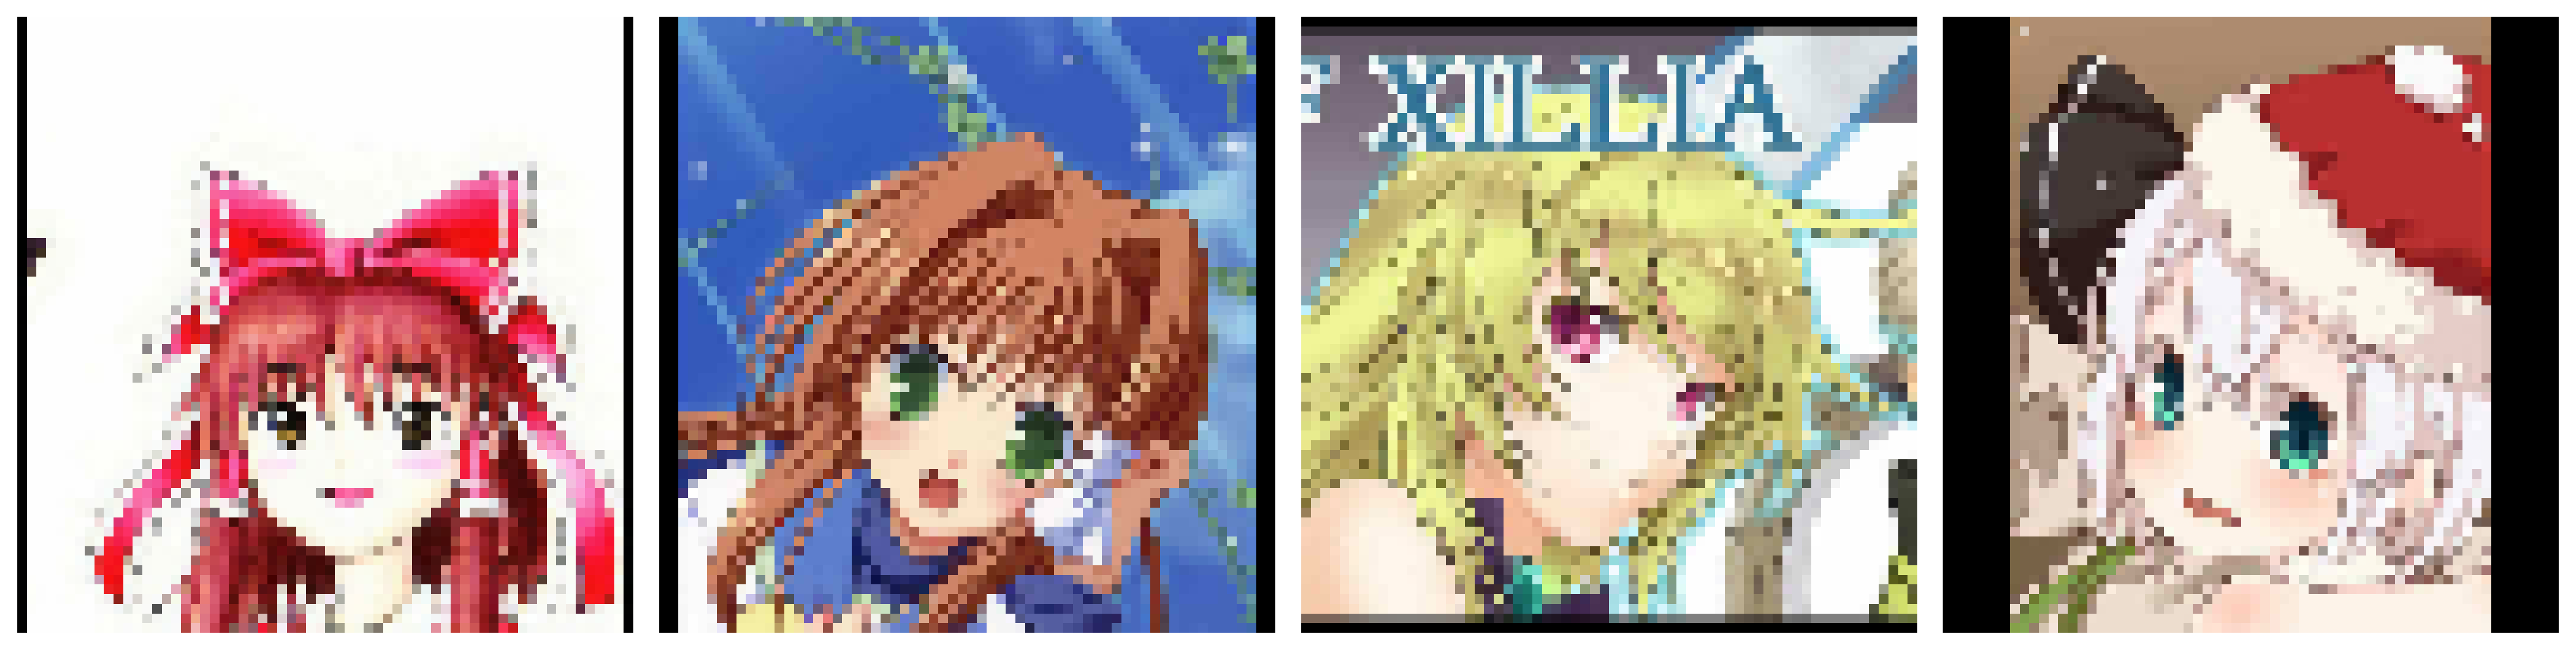

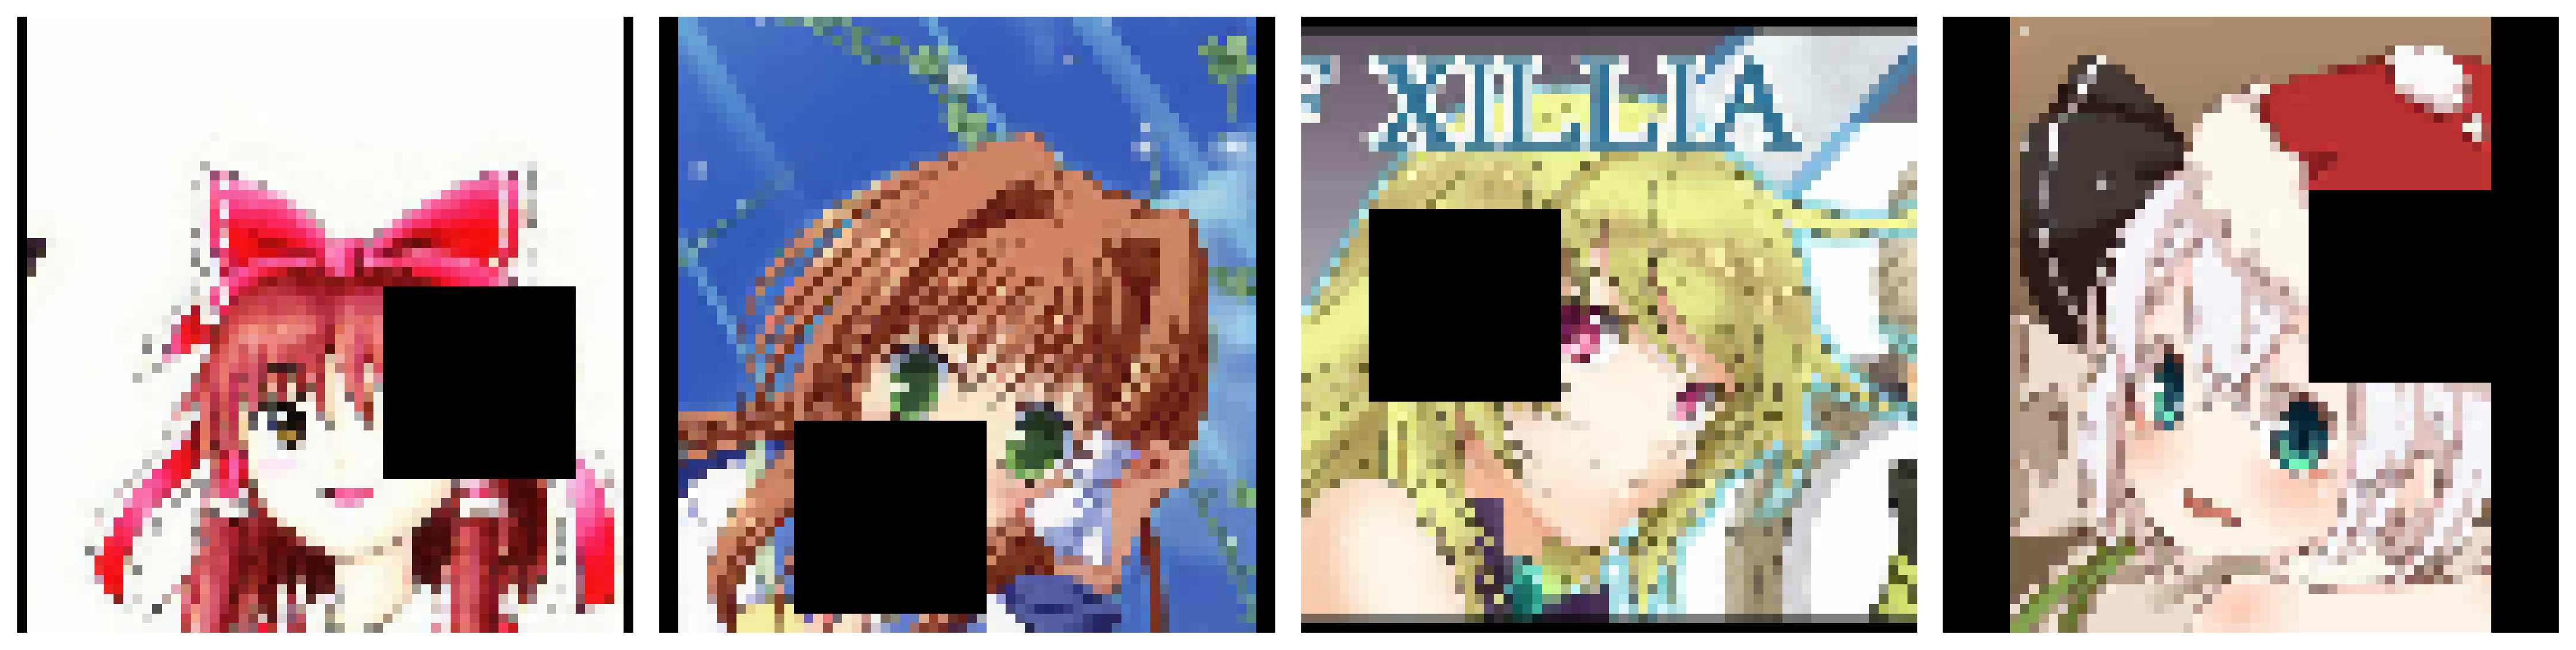

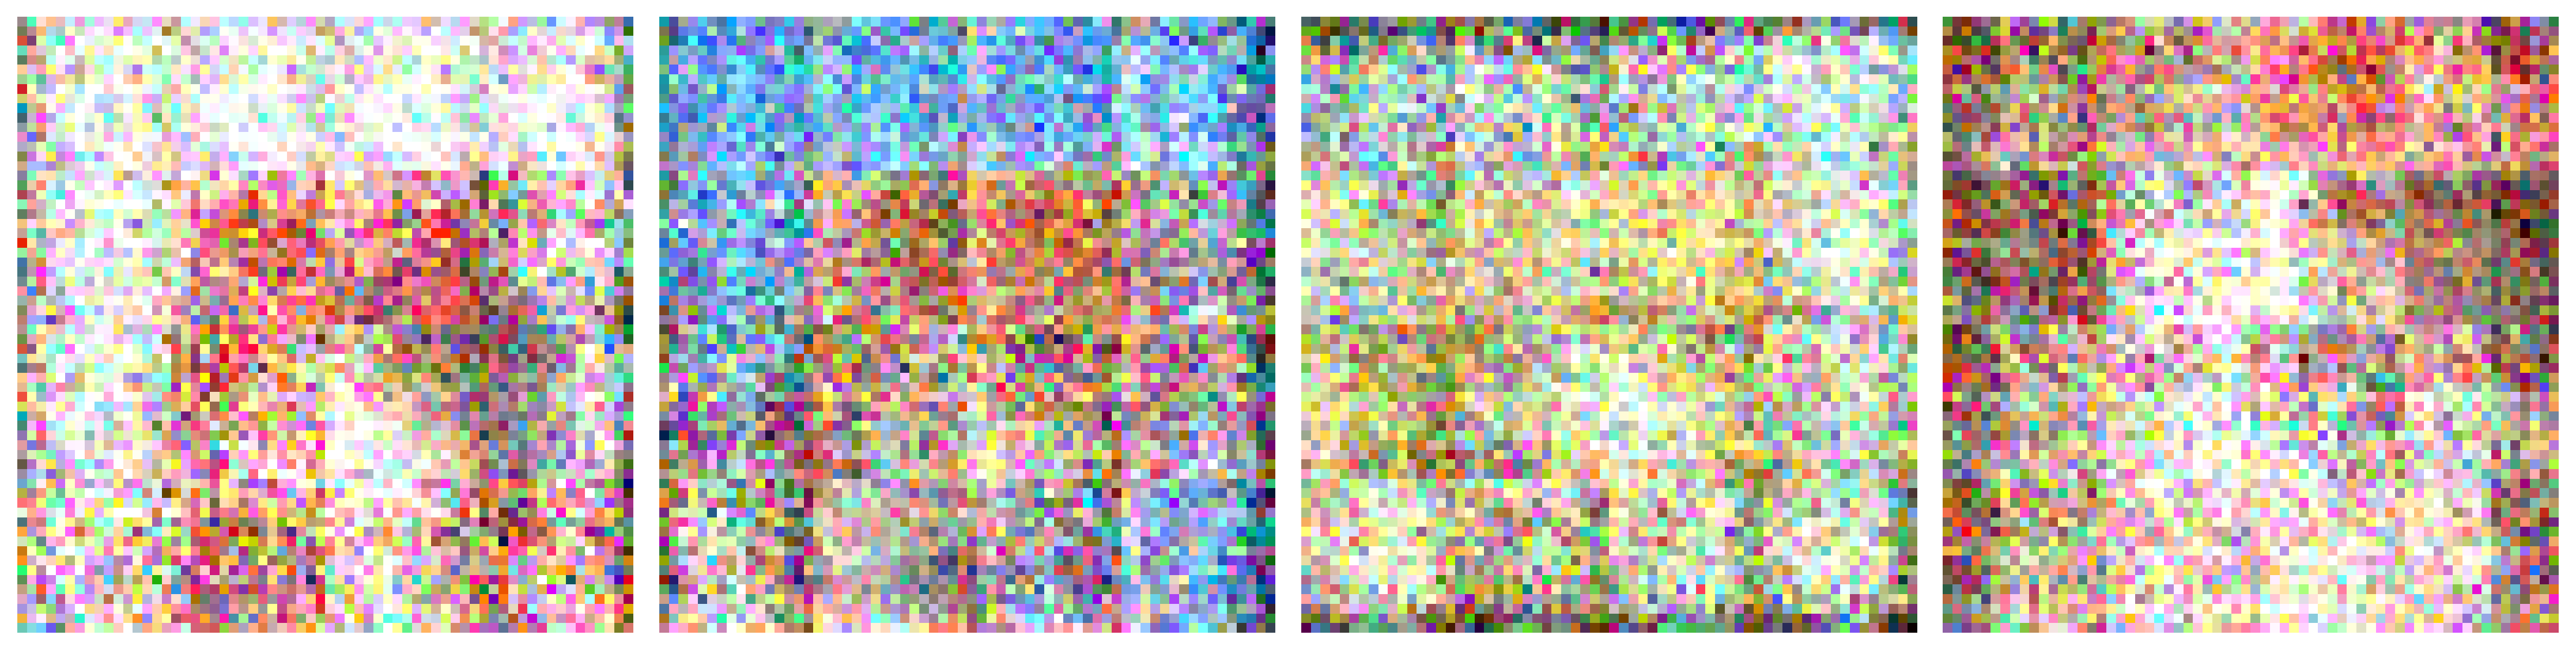

In [9]:
img, obs_mask_float = next(iter(train_ds.take(1)))
viz_grid(img)
viz_grid(apply_obsv_mask(img, obs_mask_float))
model_out = model(img, obs_mask_float)
reconstructed = reconstruct(img, model(img, obs_mask_float), obs_mask_float)
# viz_grid(reconstructed)
viz_grid(model_out)

# viz_img(model_out[0])
# viz_img(img[0])

In [ ]:
# Qualitative Eval
# visualize_unbatched_dataset(test_ds, 5)


# img = tf.image.decode_image(
#     tf.io.read_file("/home/navid/Dev/PaperTex/impl/naruto")
#     , dtype=tf.float32)
# img = tf.image.resize_with_crop_or_pad(img, H, W)
# img = tf.expand_dims(img, 0)
# tf.print(tf.shape(img))
# obvmask = tf.expand_dims(random_visibility_mask(),0)
# tf.print(tf.shape(obvmask))